In [1]:
#import xgboost as xgb

import time
import pandas as pd
import numpy as np
from sklearn.utils import graph_shortest_path
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('cities.csv')
data

CityId            X            Y
0            0   316.836739  2202.340707
1            1  4377.405972   336.602082
2            2  3454.158198  2820.053011
3            3  4688.099298  2935.898056
4            4  1010.696952  3236.750989
...        ...          ...          ...
197764  197764   149.828018  3134.756986
197765  197765  2615.299239  2267.979286
197766  197766  4775.889874  3103.846228
197767  197767  2994.230955  1931.764344
197768  197768  1354.764778  3218.100625

[197769 rows x 3 columns]

In [2]:
def findFirstPrimes(n):
    primes = [2]
    for i in range(3,n,2):
        isPrime = True
        for p in primes:
            if i%p == 0:
                isPrime = False
                break
        if isPrime == True:
            primes.append(i)
    return primes

In [3]:
numberOfRecords = data.shape[0]
relevantPrimes = findFirstPrimes(numberOfRecords)
print('number of cities: ',numberOfRecords)
print('number of relevant primes: ',len(relevantPrimes))

number of cities:  197769
number of relevant primes:  17802


5099.50214180651
3397.80982412656


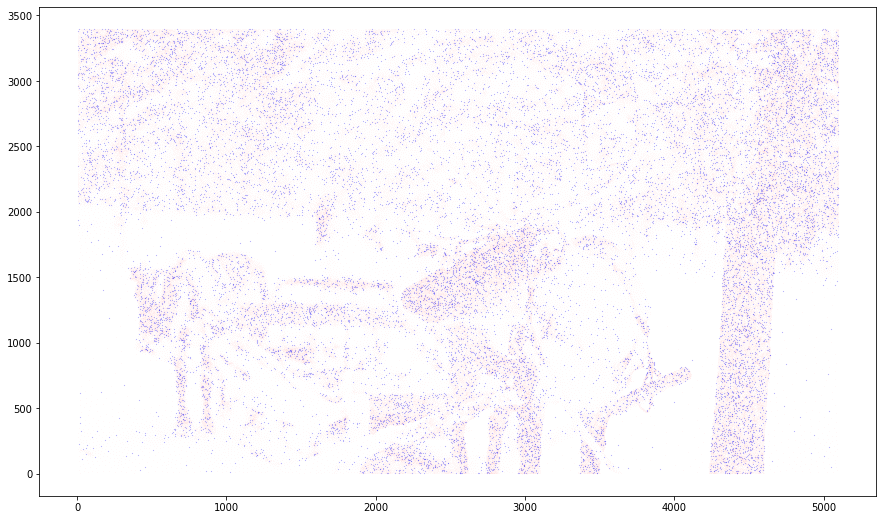

In [4]:
X = data['X']
Y = data['Y']
plt.figure(figsize=(15,9))
plt.plot(X,Y, 'ro',markersize=0.01)
Xprimes = [data.loc[p]['X'] for p in relevantPrimes]
Yprimes = [data.loc[p]['Y'] for p in relevantPrimes]
plt.plot(Xprimes,Yprimes, 'bo',markersize=0.1)
print(data['X'].max())
print(data['Y'].max())

In [5]:
def distance(city1,city2):
    id1, x1, y1 = data.loc[city1]
    id2, x2, y2 = data.loc[city2]
    vec = [(x1-x2),(y1-y2)]
    d = np.linalg.norm(vec)
    #print('DISTANCE CALL', city1,city2,d)
    return d

def calcTotalDistanceFast(myPath,includePrimeCondition=True,dMin=0,dMax=10000):
    myPath = np.array(myPath,dtype=None)
    #print('before: ',np.where(myPath==0),len(myPath))
    myPath = np.delete(myPath,np.where(myPath==0))
    #print('after:  ',np.where(myPath==0),len(myPath))
    myPath = np.insert(myPath, 0, 0, axis=0)
    myPath = np.append(myPath, 0)
    #print('after2: ',np.where(myPath==0),len(myPath))
    total_distance = 0
    longDistanceOrigList = []
    
    pathXYs=data.iloc[myPath,:]
    dX2s=np.square(np.diff(np.array(pathXYs.X)))
    dY2s=np.square(np.diff(np.array(pathXYs.Y)))

    relevantPrimes1=np.array(relevantPrimes)
    
    for step, cityId in enumerate(myPath[:-1]):
        dist = np.sqrt(dX2s[step]+dY2s[step])
        distFac = 1.0
        if includePrimeCondition:
            if (step+1)%10 == 0:
                if not np.isin([cityId],relevantPrimes1,assume_unique=True)[0]:
                    distFac = 1.1
        if step%30000 == 0:
            pass
            #print(step,total_distance)
        d=dist*distFac
        if dMin<d and d<dMax:
            longDistanceOrigList.append(step)
        total_distance += d
    return total_distance, myPath, longDistanceOrigList

In [6]:
#dumb path
myPath  = np.arange(numberOfRecords)
myPath  = np.append(myPath,0)
startTime = time.time()
totDist = calcTotalDistanceFast(myPath)
endTime = time.time()
print(totDist[0], 'running in ',endTime-startTime,'sec')
startTime = time.time()
totDist = calcTotalDistanceFast(myPath,False)
endTime = time.time()
print(totDist[0], 'running in ',endTime-startTime,'sec')  

446884407.5212135 running in  2.080152988433838 sec
443430860.2673697 running in  0.4238309860229492 sec


In [58]:
#Initial Nearest Neighbour

DISTANCETHRESHOLD=10
myPath=[0]

currentCityId = 0

for step in range(197769):
    if step%10000==0 or step > 197760:
        print('step:',step,len(myPath),data[~data.CityId.isin(myPath)].shape[0])
    currentCityX = data.loc[currentCityId,'X']
    currentCityY = data.loc[currentCityId,'Y']
    for mutiplyer in [1,5,10,50,100,500,1000]:
        distThresh = mutiplyer*DISTANCETHRESHOLD
        currentCityNeigbours = data[~data.CityId.isin(myPath) & (currentCityX-distThresh<data.X) & (data.X<currentCityX+distThresh) & (currentCityY-distThresh<data.Y) & (data.Y<currentCityY+distThresh)]
        nbrOfNeighbours = currentCityNeigbours.shape[0]
        if nbrOfNeighbours>0:
            break
            
    neighbourVectors = np.array(list(zip(currentCityNeigbours['X'].to_list(),currentCityNeigbours['Y'].to_list())))
    cityVector       = [[currentCityX,currentCityY]]
    distances        = distance_matrix(cityVector,neighbourVectors)[0]
    nearestNeighbourIndex = np.argsort(distances)[0]
    nearestNeighbourId    = int(currentCityNeigbours.iloc[nearestNeighbourIndex]['CityId'])
    myPath.append(nearestNeighbourId)
    
    currentCityId = nearestNeighbourId

totDist=calcTotalDistanceFast(myPath)
print(totDist[0])
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB01_simpleNN.csv', index=False)
print(len(myPath),myPath[0],myPath[-1])


0.0
1 0 0


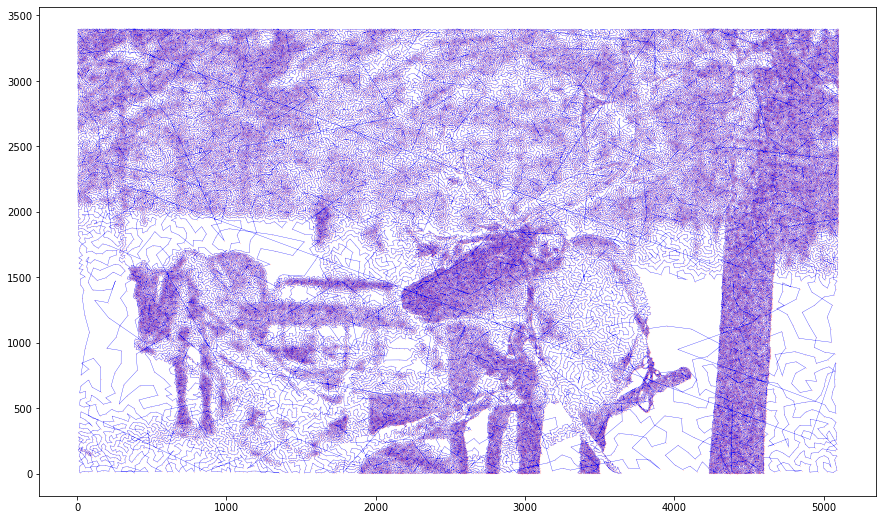

In [73]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA01_simpleNN.csv')
myPath = dataPATH['Path'].to_list()
X = data['X']
Y = data['Y']
xx=data.loc[myPath].X.to_list()
yy=data.loc[myPath].Y.to_list()
plt.figure(figsize=(15,9))
plt.plot(X,Y, 'ro',markersize=0.05)
plt.plot(xx,yy, color='blue',linewidth=0.28)

In [108]:
#Pair-switch optimizer excluding PRIME condition
dataPATH = pd.read_csv('submission_SantaPrime_chthA01_simpleNN.csv')
myPath = dataPATH['Path'].to_list()
print('without PRIME condition',calcTotalDistanceFast(myPath,False)[0])
print('with    PRIME condition',calcTotalDistanceFast(myPath,True)[0])

pathLenth = calcTotalDistanceFast(myPath,False)
for j in range(4):
    for k in range(1,197768-4,1):
        if k %10000==0:
            pathLenth = calcTotalDistanceFast(myPath,True)[0]
            print(j,k,pathLenth,len(myPath))
        k1=k
        k2=k+1
        k3=k+2
        k4=k+3
        
        if k==1:
            d12 = distance(myPath[k1],myPath[k2])
            d23 = distance(myPath[k2],myPath[k3])
            d34 = distance(myPath[k3],myPath[k4])
            d13 = distance(myPath[k1],myPath[k3])
            d24 = distance(myPath[k2],myPath[k4])
        else:
            d12 = d23
            d23 = d34
            d34 = distance(myPath[k3],myPath[k4])
            d13 = d24
            d24 = distance(myPath[k2],myPath[k4])

        d1 = d12 + d23 + d34
        d2 = d13 + d23 + d24

        if d2 < d1:
            myPath[k2:k4] = myPath[k2:k4][::-1]
        else:
            pass

print('without PRIME condition',calcTotalDistanceFast(myPath,False)[0])
print('with    PRIME condition',calcTotalDistanceFast(myPath,True)[0])

totDist=calcTotalDistanceFast(myPath)
print(totDist[0])
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB02_PairSwitch.csv', index=False)
print(len(myPath),myPath[0],myPath[-1])

without PRIME condition 1802978.1036652168
with    PRIME condition 1819236.664501894
0 10000 1819018.3855839453 197770
0 20000 1818735.1783135037 197770
0 30000 1818407.4375780032 197770
0 40000 1818113.134819438 197770
0 50000 1817682.9153811967 197770
0 60000 1817244.6545553415 197770
0 70000 1817023.8777398153 197770
0 80000 1816758.788344972 197770
0 90000 1816421.266761327 197770
0 100000 1816189.4115457644 197770
0 110000 1815758.655756225 197770
0 120000 1815502.925956962 197770
0 130000 1815009.0299663742 197770
0 140000 1814652.8576669043 197770
0 150000 1813943.885147649 197770
0 160000 1813449.765507779 197770
0 170000 1813122.5327546485 197770
0 180000 1812431.7319939362 197770
0 190000 1811460.604208293 197770
1 10000 1810040.0206054745 197770
1 20000 1809955.954587418 197770
1 30000 1809849.6863605545 197770
1 40000 1809768.7862089903 197770
1 50000 1809610.5226703861 197770
1 60000 1809479.898314682 197770
1 70000 1809452.4620216156 197770
1 80000 1809399.9294449103 1977

In [117]:
def removeCrossLoop(myPath,distMin,distMax,DISTANCEBUFFER=300,OFFSET=0):
    totalGain = 0
    currentPathStats              = calcTotalDistanceFast(myPath,False,distMin,distMax)
    currentPathLength             = currentPathStats[0]
    relevantConnectionStartPoints = currentPathStats[-1]
    #print('distCalc:',currentPathLength,'  Paths: ',len(relevantConnectionStartPoints),'  larger than: ',distMin)
    distThresh = DISTANCEBUFFER
    for point, kB in enumerate(relevantConnectionStartPoints):
        if kB < len(myPath)-1:
            if distMin < distance(myPath[kB],myPath[kB+1]):
                nbrOfPoints=len(relevantConnectionStartPoints)
                x12 = [data.loc[myPath[kB],'X'],data.loc[myPath[kB+1],'X']]
                y12 = [data.loc[myPath[kB],'Y'],data.loc[myPath[kB+1],'Y']]

                relevantCitiyIds = data[(min(x12)-distThresh<data.X) & (data.X<max(x12)+distThresh) & (min(y12)-distThresh<data.Y) & (data.Y<max(y12)+distThresh)]
                relevantPathPoints = np.where(np.isin(np.array(myPath),np.array(relevantCitiyIds.CityId.to_list())))[0]
                #print('kB=',kB,'    length=',distance(myPath[kB],myPath[kB+1]),'    relevantPathPoints: ',len(relevantPathPoints))
                for step,kA in enumerate(relevantPathPoints):
                    prog=round(step*100.0/len(relevantPathPoints),2)

                    if kA < len(myPath)-1 and kA!=kB:
                        d1=distance(myPath[kA],myPath[kA+1]) + distance(myPath[kB]  ,myPath[kB+1])
                        d2=distance(myPath[kA],myPath[kB]  ) + distance(myPath[kA+1],myPath[kB+1])

                        if kA<kB:
                            k2=kB+1
                            k1=kA+1
                        else:
                            k1=kB+1
                            k2=kA+1

                        if d2<d1-OFFSET:
                            gain = d2-d1
                            totalGain = totalGain + gain
                            #print(point,'/',nbrOfPoints,'-',prog,'%','Candidate ',kA,kB,'  :',gain,totalGain,end='\n')
                            myPath[k1:k2] = myPath[k1:k2][::-1]
                        else:
                            pass
        else:
            print(point, 'kB=',kB,' distance too short')
            
    currentPathStats              = calcTotalDistanceFast(myPath,False,distMin,distMax)
    currentPathLength             = currentPathStats[0]
    relevantConnectionStartPoints = currentPathStats[-1]
    print('distCalc:',currentPathLength,'  Paths remaining: ',len(relevantConnectionStartPoints),'  larger than: ',distMin)
    #print('---done---')
    return myPath

In [50]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA02_PairSwitch.csv')
myPath = dataPATH['Path'].to_list()
totDist=calcTotalDistanceFast(myPath,True,4000,10000)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))

myPath=removeCrossLoop(myPath,4000,10000,DISTANCEBUFFER=0,OFFSET=100)
myPath=removeCrossLoop(myPath,1000,10000,DISTANCEBUFFER=200,OFFSET=100)
myPath=removeCrossLoop(myPath,1000,10000,DISTANCEBUFFER=200,OFFSET=100)
myPath=removeCrossLoop(myPath,1000,10000,DISTANCEBUFFER=200,OFFSET=100)
myPath=removeCrossLoop(myPath,1000,10000,DISTANCEBUFFER=200,OFFSET=100)
myPath=removeCrossLoop(myPath,1000,10000,DISTANCEBUFFER=200,OFFSET=100)
myPath=removeCrossLoop(myPath,1000,10000,DISTANCEBUFFER=200,OFFSET=100)

totDist=calcTotalDistanceFast(myPath,True,1000,10000)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB03_Loop01.csv', index=False)

with    PRIME condition:  1805996.2444055865 2
distCalc: 1789886.1020286086   Paths:  2   larger than:  4000
distCalc: 1788696.2755812053   Paths remaining:  1
---done---
distCalc: 1788696.2755812053   Paths:  6   larger than:  1000
distCalc: 1788053.1222171246   Paths remaining:  5
---done---
distCalc: 1788053.1222171246   Paths:  5   larger than:  1000
distCalc: 1786413.7372404737   Paths remaining:  4
---done---
distCalc: 1786413.7372404737   Paths:  4   larger than:  1000
distCalc: 1785448.9925587343   Paths remaining:  3
---done---
distCalc: 1785448.9925587343   Paths:  3   larger than:  1000
distCalc: 1784356.2729960692   Paths remaining:  1
---done---
distCalc: 1784356.2729960692   Paths:  1   larger than:  1000
distCalc: 1784045.509353239   Paths remaining:  1
---done---
distCalc: 1784045.509353239   Paths:  1   larger than:  1000
distCalc: 1783806.8419448333   Paths remaining:  0
---done---
with    PRIME condition:  1800029.3874026465 0


In [51]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop01.csv')
myPath = dataPATH['Path'].to_list()

myPath=removeCrossLoop(myPath,900,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,900,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,800,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,800,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,700,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,700,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,600,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,600,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,600,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,500,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,500,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,500,10000,DISTANCEBUFFER=200,OFFSET=50)

totDist=calcTotalDistanceFast(myPath,True,500,10000)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB03_Loop02.csv', index=False)

distCalc: 1783806.8419448333   Paths:  5   larger than:  900
distCalc: 1783595.0311540815   Paths remaining:  4
---done---
distCalc: 1783595.0311540815   Paths:  4   larger than:  900
distCalc: 1782938.9383049412   Paths remaining:  0
---done---
distCalc: 1782938.9383049412   Paths:  3   larger than:  800
distCalc: 1782666.033334875   Paths remaining:  1
---done---
distCalc: 1782666.033334875   Paths:  1   larger than:  800
distCalc: 1782113.2656477443   Paths remaining:  0
---done---
distCalc: 1782113.2656477443   Paths:  7   larger than:  700
distCalc: 1780555.1448821868   Paths remaining:  2
---done---
distCalc: 1780555.1448821868   Paths:  2   larger than:  700
distCalc: 1780262.5740654094   Paths remaining:  0
---done---
distCalc: 1780262.5740654094   Paths:  4   larger than:  600
distCalc: 1779738.6213115766   Paths remaining:  1
---done---
distCalc: 1779738.6213115766   Paths:  1   larger than:  600
distCalc: 1779506.8626443138   Paths remaining:  0
---done---
distCalc: 1779506.

In [52]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop02.csv')
myPath = dataPATH['Path'].to_list()

myPath=removeCrossLoop(myPath,400,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,400,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,400,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,400,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,300,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,300,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,300,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,300,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,300,10000,DISTANCEBUFFER=200,OFFSET=50)
myPath=removeCrossLoop(myPath,300,10000,DISTANCEBUFFER=200,OFFSET=20)
myPath=removeCrossLoop(myPath,300,10000,DISTANCEBUFFER=200,OFFSET=20)

totDist=calcTotalDistanceFast(myPath,True,300,10000)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB03_Loop03.csv', index=False)

distCalc: 1776420.9158178717   Paths:  14   larger than:  400
distCalc: 1775747.092793666   Paths remaining:  10
---done---
distCalc: 1775747.092793666   Paths:  10   larger than:  400
distCalc: 1775391.340833521   Paths remaining:  8
---done---
distCalc: 1775391.340833521   Paths:  8   larger than:  400
distCalc: 1775113.17612842   Paths remaining:  6
---done---
distCalc: 1775113.17612842   Paths:  6   larger than:  400
distCalc: 1774345.8682942374   Paths remaining:  1
---done---
distCalc: 1774345.8682942374   Paths:  26   larger than:  300
distCalc: 1773583.667465924   Paths remaining:  21
---done---
distCalc: 1773583.667465924   Paths:  21   larger than:  300
distCalc: 1773343.6608101632   Paths remaining:  18
---done---
distCalc: 1773343.6608101632   Paths:  18   larger than:  300
distCalc: 1772865.5139255468   Paths remaining:  14
---done---
distCalc: 1772865.5139255468   Paths:  14   larger than:  300
distCalc: 1772319.7876136748   Paths remaining:  9
---done---
distCalc: 177231

In [64]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop03.csv')
myPath = dataPATH['Path'].to_list()

myPath=removeCrossLoop(myPath,250,10000,DISTANCEBUFFER=200,OFFSET=20)
myPath=removeCrossLoop(myPath,250,10000,DISTANCEBUFFER=200,OFFSET=20)
myPath=removeCrossLoop(myPath,250,10000,DISTANCEBUFFER=200,OFFSET=20)
myPath=removeCrossLoop(myPath,200,10000,DISTANCEBUFFER=200,OFFSET=20)
myPath=removeCrossLoop(myPath,200,10000,DISTANCEBUFFER=200,OFFSET=20)
myPath=removeCrossLoop(myPath,200,10000,DISTANCEBUFFER=200,OFFSET=20)
myPath=removeCrossLoop(myPath,200,10000,DISTANCEBUFFER=200,OFFSET=20)
myPath=removeCrossLoop(myPath,200,10000,DISTANCEBUFFER=200,OFFSET=20)
myPath=removeCrossLoop(myPath,200,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,200,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,200,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,200,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,200,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,150,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,150,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,150,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,150,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,150,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,150,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,150,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,150,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,150,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,150,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,150,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,150,10000,DISTANCEBUFFER=100,OFFSET=20)
myPath=removeCrossLoop(myPath,150,10000,DISTANCEBUFFER=100,OFFSET=10)

totDist=calcTotalDistanceFast(myPath,True,150,10000)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB03_Loop04.csv', index=False)

distCalc: 1771715.1145271128   Paths:  26   larger than:  250
distCalc: 1771386.8570354236   Paths remaining:  21
---done---
distCalc: 1771386.8570354236   Paths:  21   larger than:  250
distCalc: 1770188.660583737   Paths remaining:  9
---done---
distCalc: 1770188.660583737   Paths:  9   larger than:  250
distCalc: 1770064.4733926023   Paths remaining:  8
---done---
distCalc: 1770064.4733926023   Paths:  62   larger than:  200
distCalc: 1769499.5850174287   Paths remaining:  53
---done---
distCalc: 1769499.5850174287   Paths:  53   larger than:  200
distCalc: 1768806.790167256   Paths remaining:  43
---done---
distCalc: 1768806.790167256   Paths:  43   larger than:  200
distCalc: 1768742.899320164   Paths remaining:  42
---done---
distCalc: 1768742.899320164   Paths:  42   larger than:  200
distCalc: 1768684.8571478943   Paths remaining:  41
---done---
distCalc: 1768684.8571478943   Paths:  41   larger than:  200
distCalc: 1768664.349482462   Paths remaining:  40
---done---
distCalc: 

In [108]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop04.csv')
myPath = dataPATH['Path'].to_list()

for k in range(13):
    myPath=removeCrossLoop(myPath,125,10000,DISTANCEBUFFER=100,OFFSET=20)

for k in range(20):
    myPath=removeCrossLoop(myPath,100,10000,DISTANCEBUFFER=100,OFFSET=0)

totDist=calcTotalDistanceFast(myPath,True,100,10000)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB03_Loop05.csv', index=False)

distCalc: 1759158.5230443715   Paths:  119   larger than:  125
distCalc: 1758202.993999016   Paths remaining:  101
---done---
distCalc: 1758202.993999016   Paths:  101   larger than:  125
distCalc: 1757725.0116484975   Paths remaining:  90
---done---
distCalc: 1757725.0116484975   Paths:  90   larger than:  125
distCalc: 1757228.6150272335   Paths remaining:  79
---done---
distCalc: 1757228.6150272335   Paths:  79   larger than:  125
distCalc: 1757043.430152361   Paths remaining:  74
---done---
distCalc: 1757043.430152361   Paths:  74   larger than:  125
distCalc: 1756159.3325058287   Paths remaining:  53
---done---
distCalc: 1756159.3325058287   Paths:  53   larger than:  125
distCalc: 1755920.9580983077   Paths remaining:  47
---done---
distCalc: 1755920.9580983077   Paths:  47   larger than:  125
distCalc: 1755571.2396352359   Paths remaining:  40
---done---
distCalc: 1755571.2396352359   Paths:  40   larger than:  125
distCalc: 1755210.0115820346   Paths remaining:  32
---done---
d

In [162]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop05.csv')
myPath = dataPATH['Path'].to_list()

print(sorted([round(distance(myPath[k],myPath[k+1]),2) for k in calcTotalDistanceFast(myPath,includePrimeCondition=True,dMin=150,dMax=10000)[-1]]))
myPath=removeCrossLoop(myPath,150,300,DISTANCEBUFFER=200,OFFSET=0)

print(sorted([round(distance(myPath[k],myPath[k+1]),2) for k in calcTotalDistanceFast(myPath,includePrimeCondition=True,dMin=125,dMax=150)[-1]]))
myPath=removeCrossLoop(myPath,125,150,DISTANCEBUFFER=200,OFFSET=0)

print(sorted([round(distance(myPath[k],myPath[k+1]),2) for k in calcTotalDistanceFast(myPath,includePrimeCondition=True,dMin=100,dMax=125)[-1]]))
myPath=removeCrossLoop(myPath,100,125,DISTANCEBUFFER=200,OFFSET=0)
myPath=removeCrossLoop(myPath,100,125,DISTANCEBUFFER=100,OFFSET=0)
myPath=removeCrossLoop(myPath,100,125,DISTANCEBUFFER=100,OFFSET=0)

for k in range(11):
    myPath=removeCrossLoop(myPath,90,100,DISTANCEBUFFER=100,OFFSET=0)

for k in range(20):
    myPath=removeCrossLoop(myPath,80,90,DISTANCEBUFFER=100,OFFSET=0)

for k in range(17):
    myPath=removeCrossLoop(myPath,70,80,DISTANCEBUFFER=100,OFFSET=0)

for k in range(21):
    myPath=removeCrossLoop(myPath,60,70,DISTANCEBUFFER=100,OFFSET=0)

    
totDist=calcTotalDistanceFast(myPath,True,60,70)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB03_Loop06.csv', index=False)

[168.03, 221.89, 235.85]
distCalc: 1748197.2356672087   Paths remaining:  3   larger than:  150
[121.33, 126.21, 127.72, 131.03, 135.99, 137.25]
distCalc: 1748197.2356672087   Paths remaining:  5   larger than:  125
[93.39, 94.37, 94.42, 94.71, 95.08, 96.11, 96.63, 97.41, 97.94, 98.05, 99.11, 100.63, 100.73, 100.76, 102.96, 103.5, 103.69, 103.95, 105.34, 105.53, 108.04, 108.41, 109.64, 109.69, 112.1, 112.17, 113.92, 114.8, 115.3, 116.1, 116.44, 117.17, 118.05, 118.22, 120.52, 120.6, 121.55, 121.99, 122.85, 123.62, 124.21, 124.43]
distCalc: 1748132.1336176065   Paths remaining:  30   larger than:  100
distCalc: 1747978.1109034712   Paths remaining:  24   larger than:  100
distCalc: 1747930.3629631824   Paths remaining:  23   larger than:  100
distCalc: 1747412.4275748883   Paths remaining:  121   larger than:  90
distCalc: 1747212.054424802   Paths remaining:  113   larger than:  90
distCalc: 1746865.5275846405   Paths remaining:  100   larger than:  90
distCalc: 1746275.6679306915   Pa

In [166]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop06.csv')
myPath = dataPATH['Path'].to_list()

for k in range(30):
    myPath=removeCrossLoop(myPath,50,60,DISTANCEBUFFER=50,OFFSET=0)

totDist=calcTotalDistanceFast(myPath,True,50,60)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB03_Loop07.csv', index=False)

distCalc: 1728623.161441546   Paths remaining:  654   larger than:  50
distCalc: 1728452.4123230225   Paths remaining:  646   larger than:  50
distCalc: 1727837.6042215605   Paths remaining:  611   larger than:  50
distCalc: 1727596.2629011434   Paths remaining:  598   larger than:  50
distCalc: 1727347.1313107293   Paths remaining:  585   larger than:  50
distCalc: 1726827.7443514674   Paths remaining:  559   larger than:  50
distCalc: 1726307.1064083492   Paths remaining:  535   larger than:  50
distCalc: 1726172.698758503   Paths remaining:  524   larger than:  50
distCalc: 1725869.149777929   Paths remaining:  514   larger than:  50
distCalc: 1725651.164153983   Paths remaining:  505   larger than:  50
distCalc: 1725511.9944931024   Paths remaining:  497   larger than:  50
distCalc: 1725345.5761002845   Paths remaining:  487   larger than:  50
distCalc: 1724688.870968358   Paths remaining:  452   larger than:  50
distCalc: 1724080.0466044815   Paths remaining:  417   larger than:  

In [168]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop07.csv')
myPath = dataPATH['Path'].to_list()

for k in range(30):
    myPath=removeCrossLoop(myPath,40,50,DISTANCEBUFFER=20,OFFSET=0)

myPath=removeCrossLoop(myPath,40,50,DISTANCEBUFFER=50,OFFSET=0)
    
totDist=calcTotalDistanceFast(myPath,True,40,50)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB03_Loop08.csv', index=False)

distCalc: 1718350.2378937486   Paths remaining:  1135   larger than:  40
distCalc: 1718090.7197221706   Paths remaining:  1112   larger than:  40
distCalc: 1716363.0243834413   Paths remaining:  967   larger than:  40
distCalc: 1716210.4942334925   Paths remaining:  958   larger than:  40
distCalc: 1716060.9403239677   Paths remaining:  947   larger than:  40
distCalc: 1715964.6107970153   Paths remaining:  938   larger than:  40
distCalc: 1715783.464136685   Paths remaining:  922   larger than:  40
distCalc: 1714577.757265008   Paths remaining:  821   larger than:  40
distCalc: 1714441.9086365101   Paths remaining:  809   larger than:  40
distCalc: 1714307.4284490955   Paths remaining:  799   larger than:  40
distCalc: 1713221.7224237297   Paths remaining:  703   larger than:  40
distCalc: 1712148.2512649882   Paths remaining:  617   larger than:  40
distCalc: 1711275.6277188226   Paths remaining:  554   larger than:  40
distCalc: 1710651.664604605   Paths remaining:  509   larger tha

In [188]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop08.csv')
myPath = dataPATH['Path'].to_list()

for k in range(60):
    myPath=removeCrossLoop(myPath,30,40,DISTANCEBUFFER=10,OFFSET=0)

for k in range(5):
    myPath=removeCrossLoop(myPath,30,40,DISTANCEBUFFER=20,OFFSET=0)

for k in range(60):
    myPath=removeCrossLoop(myPath,20,30,DISTANCEBUFFER=10,OFFSET=0)
    
totDist=calcTotalDistanceFast(myPath,True,20,30)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB03_Loop09.csv', index=False)

distCalc: 1704434.3560660544   Paths remaining:  2251   larger than:  30
distCalc: 1703719.0094847449   Paths remaining:  2179   larger than:  30
distCalc: 1703502.403377216   Paths remaining:  2157   larger than:  30
distCalc: 1703282.212295919   Paths remaining:  2136   larger than:  30
distCalc: 1703024.8620910267   Paths remaining:  2111   larger than:  30
distCalc: 1702727.3664264923   Paths remaining:  2085   larger than:  30
distCalc: 1701858.510348966   Paths remaining:  2011   larger than:  30
distCalc: 1701381.3301373303   Paths remaining:  1959   larger than:  30
distCalc: 1701110.443457664   Paths remaining:  1932   larger than:  30
distCalc: 1700905.5341513595   Paths remaining:  1912   larger than:  30
distCalc: 1699239.3618767022   Paths remaining:  1751   larger than:  30
distCalc: 1698925.215792736   Paths remaining:  1725   larger than:  30
distCalc: 1698700.1118108558   Paths remaining:  1708   larger than:  30
distCalc: 1698377.1834737351   Paths remaining:  1670   

In [196]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop09.csv')
myPath = dataPATH['Path'].to_list()

for k in range(30):
    myPath=removeCrossLoop(myPath,10,20,DISTANCEBUFFER=5,OFFSET=0)

myPath=removeCrossLoop(myPath,10,20,DISTANCEBUFFER=10,OFFSET=0)

totDist=calcTotalDistanceFast(myPath,True,10,20)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB03_Loop10.csv', index=False)

distCalc: 1636705.9807881997   Paths remaining:  39870   larger than:  10
distCalc: 1628297.138243738   Paths remaining:  38703   larger than:  10
distCalc: 1621791.1078083364   Paths remaining:  37790   larger than:  10
distCalc: 1616297.1447303318   Paths remaining:  36994   larger than:  10
distCalc: 1611494.0242047606   Paths remaining:  36301   larger than:  10
distCalc: 1607604.381091078   Paths remaining:  35723   larger than:  10
distCalc: 1604743.9696757267   Paths remaining:  35297   larger than:  10
distCalc: 1602207.1857685263   Paths remaining:  34939   larger than:  10
distCalc: 1600044.216645219   Paths remaining:  34633   larger than:  10
distCalc: 1598217.891175464   Paths remaining:  34388   larger than:  10
distCalc: 1596774.312819471   Paths remaining:  34150   larger than:  10
distCalc: 1595241.3981859172   Paths remaining:  33927   larger than:  10
distCalc: 1594071.556811972   Paths remaining:  33759   larger than:  10
distCalc: 1592895.0396382536   Paths remaini

In [229]:
#Pair-switch optimizer excluding PRIME condition
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop10.csv')
myPath = dataPATH['Path'].to_list()
print('without PRIME condition',calcTotalDistanceFast(myPath,False)[0])
print('with    PRIME condition',calcTotalDistanceFast(myPath,True)[0])

pathLenth = calcTotalDistanceFast(myPath,False)
for j in range(4):
    for k in range(1,197768-4,1):
        if k %10000==0:
            pathLenth = calcTotalDistanceFast(myPath,True)[0]
            print(j,k,pathLenth,len(myPath))
        k1=k
        k2=k+1
        k3=k+2
        k4=k+3
        
        if k==1:
            d12 = distance(myPath[k1],myPath[k2])
            d23 = distance(myPath[k2],myPath[k3])
            d34 = distance(myPath[k3],myPath[k4])
            d13 = distance(myPath[k1],myPath[k3])
            d24 = distance(myPath[k2],myPath[k4])
        else:
            d12 = d23
            d23 = d34
            d34 = distance(myPath[k3],myPath[k4])
            d13 = d24
            d24 = distance(myPath[k2],myPath[k4])

        d1 = d12 + d23 + d34
        d2 = d13 + d23 + d24

        if d2 < d1:
            myPath[k2:k4] = myPath[k2:k4][::-1]
        else:
            pass

print('without PRIME condition',calcTotalDistanceFast(myPath,False)[0])
print('with    PRIME condition',calcTotalDistanceFast(myPath,True)[0])

totDist=calcTotalDistanceFast(myPath)
print(totDist[0])
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthA03_Loop10pair.csv', index=False)
print(len(myPath),myPath[0],myPath[-1])

without PRIME condition 1584870.9972581745
with    PRIME condition 1599250.6208289817
0 10000 1599171.1136037628 197770
0 20000 1599103.268401214 197770
0 30000 1599055.639469549 197770
0 40000 1598869.4612044026 197770
0 50000 1598741.552824582 197770
0 60000 1598656.264084534 197770
0 70000 1598519.698693195 197770
0 80000 1598408.356439567 197770
0 90000 1598312.526379767 197770
0 100000 1598212.4221268853 197770
0 110000 1598137.9518982116 197770
0 120000 1598043.2940314366 197770
0 130000 1597935.3668370233 197770
0 140000 1597788.9158049095 197770
0 150000 1597678.5518306561 197770
0 160000 1597544.4905961356 197770
0 170000 1597423.1609944156 197770
0 180000 1597353.7414431751 197770
0 190000 1597286.8169457729 197770
1 10000 1597221.7360324045 197770
1 20000 1597200.541138517 197770
1 30000 1597190.3776789429 197770
1 40000 1597178.6968578757 197770
1 50000 1597147.1457164676 197770
1 60000 1597116.35313768 197770
1 70000 1597085.662488543 197770
1 80000 1597068.1813101484 1977

In [290]:
def removeCrossLoopIndividual(myPath,distMin,distMax,DISTANCEBUFFER=300,OFFSET=0):
    totalGain = 0
    distThresh = DISTANCEBUFFER
    for kB in range(len(myPath)-1):
        if kB%10000==0:
            print(round(totalGain,0),end=' ')
        x12 = [data.loc[myPath[kB],'X'],data.loc[myPath[kB+1],'X']]
        y12 = [data.loc[myPath[kB],'Y'],data.loc[myPath[kB+1],'Y']]

        relevantCitiyIds = data[(min(x12)-distThresh<data.X) & (data.X<max(x12)+distThresh) & (min(y12)-distThresh<data.Y) & (data.Y<max(y12)+distThresh)]
        relevantPathPoints = np.where(np.isin(np.array(myPath),np.array(relevantCitiyIds.CityId.to_list())))[0]
        #print('kB=',kB,'    length=',distance(myPath[kB],myPath[kB+1]),'    relevantPathPoints: ',len(relevantPathPoints))
        for step,kA in enumerate(relevantPathPoints):

            if kA < len(myPath)-1 and kA!=kB:
                d1=distance(myPath[kA],myPath[kA+1]) + distance(myPath[kB]  ,myPath[kB+1])
                d2=distance(myPath[kA],myPath[kB]  ) + distance(myPath[kA+1],myPath[kB+1])

                if kA<kB:
                    k2=kB+1
                    k1=kA+1
                else:
                    k1=kB+1
                    k2=kA+1

                if d2<d1-OFFSET:
                    gain = d2-d1
                    totalGain = totalGain + gain
                    #print(point,'/',nbrOfPoints,'-',prog,'%','Candidate ',kA,kB,'  :',gain,totalGain,end='\n')
                    myPath[k1:k2] = myPath[k1:k2][::-1]
                else:
                    pass
            
    currentPathStats              = calcTotalDistanceFast(myPath,False)
    currentPathLength             = currentPathStats[0]
    print('\n distCalc:',currentPathLength)
    #print('---done---')
    return myPath

In [301]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop10pair.csv')
myPath = np.array(dataPATH['Path'].to_list())

myPath=removeCrossLoopIndividual(myPath,0,10000,0,0)
myPath=removeCrossLoopIndividual(myPath,0,10000,0,0)
myPath=removeCrossLoopIndividual(myPath,0,10000,0,0)
myPath=removeCrossLoopIndividual(myPath,0,10000,5,0)
myPath=removeCrossLoopIndividual(myPath,0,10000,5,0)
myPath=removeCrossLoopIndividual(myPath,0,10000,5,0)
myPath=removeCrossLoopIndividual(myPath,0,10000,10,0)

totDist=calcTotalDistanceFast(myPath,True,20,30)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB03_Loop11.csv', index=False)

0 -51.0 -67.0 -81.0 -138.0 -242.0 -310.0 -486.0 -605.0 -658.0 -781.0 -786.0 -790.0 -849.0 -962.0 -1087.0 -1200.0 -1306.0 -1395.0 -1413.0 
 distCalc: 1580991.3343643562
0 -10.0 -10.0 -12.0 -21.0 -32.0 -47.0 -56.0 -63.0 -63.0 -63.0 -94.0 -94.0 -100.0 -125.0 -128.0 -144.0 -168.0 -176.0 -176.0 
 distCalc: 1580808.6088226254
0 0 0 -6.0 -12.0 -15.0 -15.0 -15.0 -15.0 -15.0 -18.0 -22.0 -22.0 -22.0 -22.0 -27.0 -41.0 -57.0 -57.0 -57.0 
 distCalc: 1580747.4425383674
0 -159.0 -236.0 -364.0 -598.0 -811.0 -1141.0 -1350.0 -1465.0 -1697.0 -1940.0 -2194.0 -2323.0 -2338.0 -2360.0 -2410.0 -2529.0 -2736.0 -3027.0 -3050.0 
 distCalc: 1577662.7280412198
0 -10.0 -11.0 -64.0 -76.0 -120.0 -147.0 -169.0 -186.0 -190.0 -204.0 -236.0 -236.0 -242.0 -245.0 -253.0 -255.0 -266.0 -292.0 -292.0 
 distCalc: 1577366.5901927538
0 0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 -2.0 
 distCalc: 1577365.0040571676
0 -20.0 -24.0 -54.0 -85.0 -130.0 -177.0 -305.0 -343.0 -360.0 -406.0 -435.

In [317]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop11.csv')
myPath = np.array(dataPATH['Path'].to_list())
totDist=calcTotalDistanceFast(myPath,True,100,150)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))

myPath=removeCrossLoop(myPath,10,20,10,0)
myPath=removeCrossLoop(myPath,10,20,20,0)
myPath=removeCrossLoop(myPath,10,20,30,0)

totDist=calcTotalDistanceFast(myPath,True,200,10000)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB03_Loop12.csv', index=False)

with    PRIME condition:  1591436.1091686436 29
distCalc: 1577203.2585040778   Paths remaining:  2   larger than:  200
distCalc: 1577203.2585040778   Paths remaining:  1   larger than:  150
distCalc: 1577203.2585040778   Paths remaining:  29   larger than:  100
with    PRIME condition:  1591436.1091686436 2


In [327]:
totDist=calcTotalDistanceFast(myPath,True,200,10000)
print('with    PRIME condition: ',totDist[0],len(totDist[-1]))
pd.DataFrame(totDist[1],columns=['Path']).to_csv('submission_SantaPrime_chthB03_Loop12.csv', index=False)

with    PRIME condition:  1590864.3447134169 2


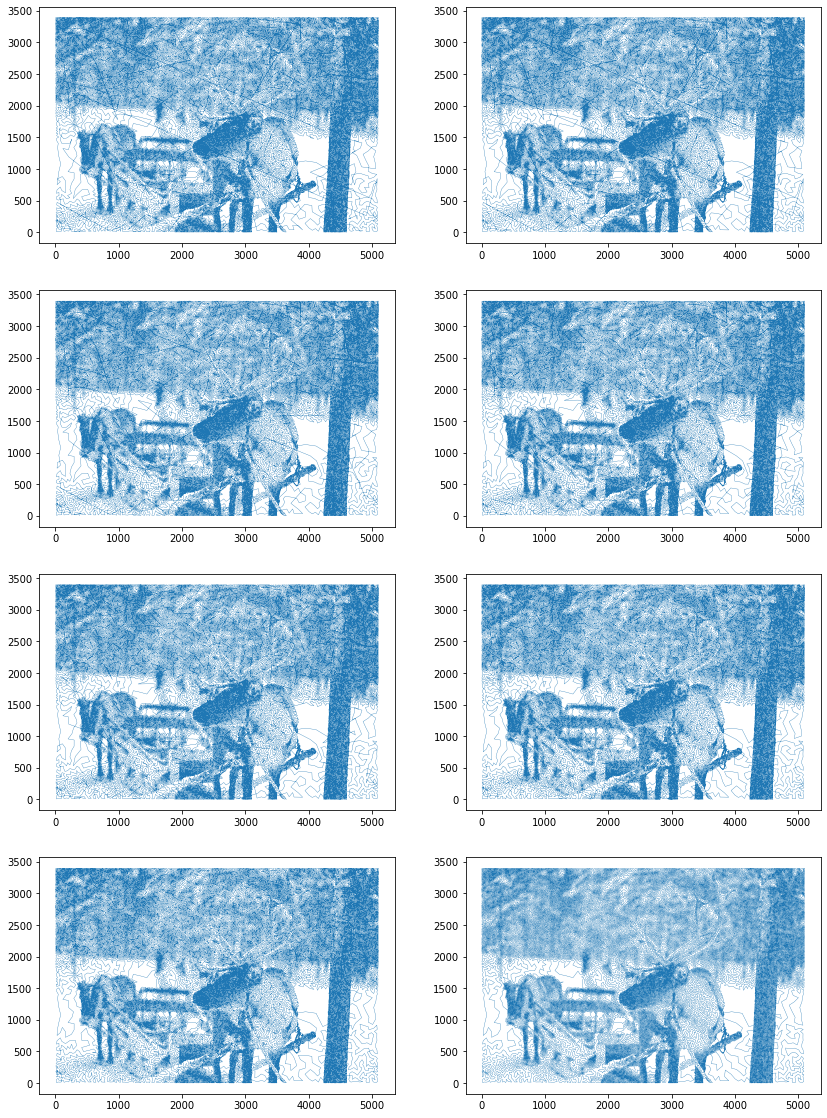

In [305]:
dataPATH = pd.read_csv('submission_SantaPrime_chthA01_simpleNN.csv')
myPath = np.array(dataPATH['Path'].to_list())
X1=data.loc[myPath].X.to_list()
Y1=data.loc[myPath].Y.to_list()

dataPATH = pd.read_csv('submission_SantaPrime_chthA02_PairSwitch.csv')
myPath = np.array(dataPATH['Path'].to_list())
X2=data.loc[myPath].X.to_list()
Y2=data.loc[myPath].Y.to_list()

dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop01.csv')
myPath = np.array(dataPATH['Path'].to_list())
X3=data.loc[myPath].X.to_list()
Y3=data.loc[myPath].Y.to_list()

dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop02.csv')
myPath = np.array(dataPATH['Path'].to_list())
X4=data.loc[myPath].X.to_list()
Y4=data.loc[myPath].Y.to_list()

dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop03.csv')
myPath = np.array(dataPATH['Path'].to_list())
X5=data.loc[myPath].X.to_list()
Y5=data.loc[myPath].Y.to_list()

dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop04.csv')
myPath = np.array(dataPATH['Path'].to_list())
X6=data.loc[myPath].X.to_list()
Y6=data.loc[myPath].Y.to_list()

dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop05.csv')
myPath = np.array(dataPATH['Path'].to_list())
X7=data.loc[myPath].X.to_list()
Y7=data.loc[myPath].Y.to_list()

dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop11.csv')
myPath = np.array(dataPATH['Path'].to_list())
X8=data.loc[myPath].X.to_list()
Y8=data.loc[myPath].Y.to_list()

plt.figure(figsize=(14,20))
plt.subplot(421)
plt.plot(X1,Y1,linewidth=0.32)
plt.subplot(422)
plt.plot(X2,Y2,linewidth=0.32)
plt.subplot(423)
plt.plot(X3,Y3,linewidth=0.32)
plt.subplot(424)
plt.plot(X4,Y4,linewidth=0.32)
plt.subplot(425)
plt.plot(X5,Y5,linewidth=0.32)
plt.subplot(426)
plt.plot(X6,Y6,linewidth=0.32)
plt.subplot(427)
plt.plot(X7,Y7,linewidth=0.32)
plt.subplot(428)
plt.plot(X8,Y8,linewidth=0.32)

324.443240482392 316.83673906150904 2209.76354995075 2202.34070733524


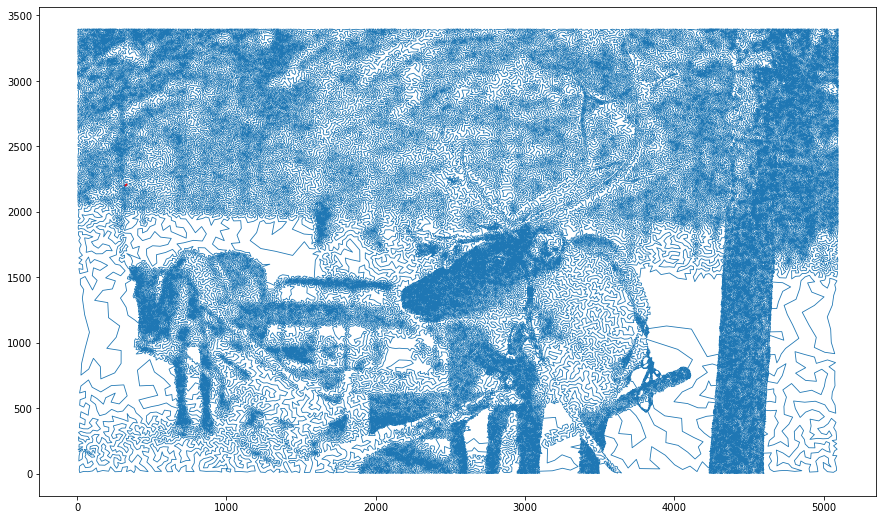

In [304]:
#dataPATH = pd.read_csv('submission_SantaPrime_chthA01_simpleNN.csv')
#dataPATH = pd.read_csv('submission_SantaPrime_chthA02_PairSwitch.csv')
#dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop01.csv')
#dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop02.csv')
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop11.csv')

myPath = np.array(dataPATH['Path'].to_list())
X = data['X']
Y = data['Y']
N1, N2= [0,197770]
XPATH = data.loc[dataPATH['Path'][N1:N2]]['X'].to_list()
YPATH = data.loc[dataPATH['Path'][N1:N2]]['Y'].to_list()
    
    
plt.figure(figsize=(15,9))
plt.plot(XPATH,YPATH,linewidth=0.82)

d=calcTotalDistanceFast(myPath)
originOfLongs = d[-1]
#for k in originOfLongs:
#    id1, x1, y1 = data.loc[myPath[k]]
#    id2, x2, y2 = data.loc[myPath[k+1]]
#    plt.plot([x1,x2],[y1,y2],linewidth=0.82,color='red')

k=197768
id1, x1, y1 = data.loc[myPath[k]]
id2, x2, y2 = data.loc[myPath[k+1]]
print(x1,x2,y1,y2)
plt.plot([x1,x2],[y1,y2],'bo',markersize=0.82,color='red')

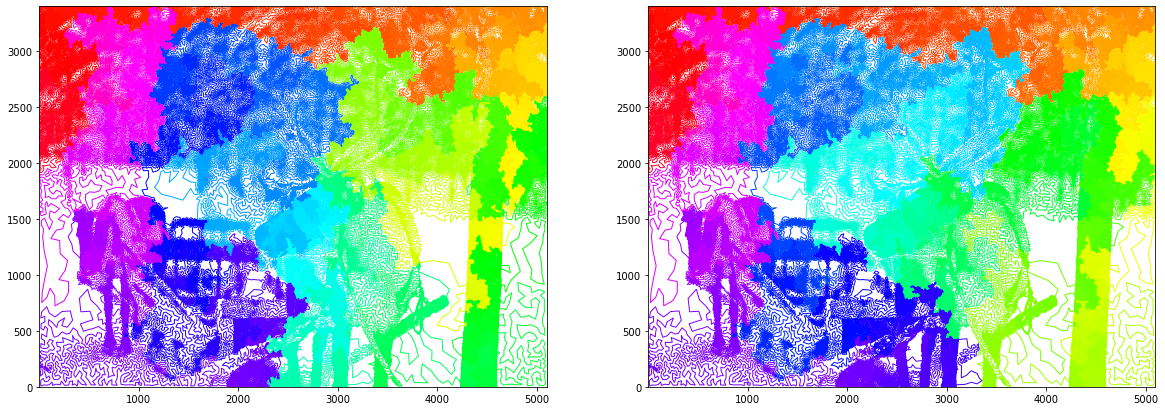

In [328]:
import matplotlib
from matplotlib import cm
cmap=cm.gist_rainbow

dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop12.csv')
myPath1 = np.array(dataPATH['Path'].to_list())
dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop11.csv')
myPath2 = np.array(dataPATH['Path'].to_list())

n = len(myPath1)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
for i in range(201):
    ind = myPath1[n//200*i:min(n, n//200*(i+1)+1)]
    ax1.plot(data.loc[ind].X.to_list(), data.loc[ind].Y.to_list(), color=cmap(i/200.0), linewidth=1)
    ax1.autoscale(tight=True)

for i in range(201):
    ind = myPath2[n//200*i:min(n, n//200*(i+1)+1)]
    ax2.plot(data.loc[ind].X.to_list(), data.loc[ind].Y.to_list(), color=cmap(i/200.0), linewidth=1)
    ax2.autoscale(tight=True)


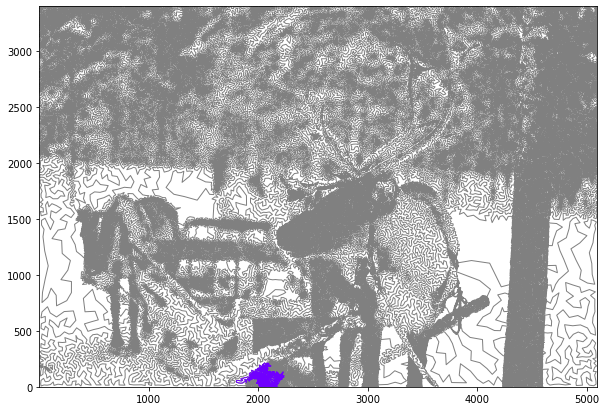

In [335]:
import matplotlib
from matplotlib import cm
cmap=cm.gist_rainbow

dataPATH = pd.read_csv('submission_SantaPrime_chthA03_Loop12.csv')
myPath1 = np.array(dataPATH['Path'].to_list())

n = len(myPath1)
fig, ax1 = plt.subplots(figsize=(10,7))
for i in range(201):
    ind = myPath1[n//200*i:min(n, n//200*(i+1)+1)]
    ax1.plot(data.loc[ind].X.to_list(), data.loc[ind].Y.to_list(), color='grey', linewidth=1)
    ax1.autoscale(tight=True)
    if i == 170:
        ax1.plot(data.loc[ind].X.to_list(), data.loc[ind].Y.to_list(), color=cmap(i/200.0), linewidth=1)
    